In [1]:
import os
import glob
import h5py
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from keras import backend as K

import keras
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Flatten, Dense, Activation, Reshape

Using TensorFlow backend.


In [2]:
keras.backend.set_image_dim_ordering('tf')
weights_path = 'yolo-tiny.weights'
is_freeze = True

In [3]:
model = Sequential()
model.add(Convolution2D(16, 3, 3,input_shape=(448,448,3),border_mode='same',subsample=(1,1), 
                        activation=LeakyReLU(alpha=0.1), trainable=not is_freeze))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32,3,3 ,border_mode='same', 
                        activation=LeakyReLU(alpha=0.1), trainable=not is_freeze))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(64,3,3 ,border_mode='same', 
                        activation=LeakyReLU(alpha=0.1), trainable=not is_freeze))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(128,3,3 ,border_mode='same', 
                        activation=LeakyReLU(alpha=0.1), trainable=not is_freeze))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(256,3,3 ,border_mode='same', 
                        activation=LeakyReLU(alpha=0.1), trainable=not is_freeze))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(512,3,3 ,border_mode='same', 
                        activation=LeakyReLU(alpha=0.1), trainable=not is_freeze))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(1024,3,3 ,border_mode='same', activation=LeakyReLU(alpha=0.1), trainable=not is_freeze))
model.add(Convolution2D(1024,3,3 ,border_mode='same', activation=LeakyReLU(alpha=0.1), trainable=not is_freeze))
model.add(Convolution2D(1024,3,3 ,border_mode='same', activation=LeakyReLU(alpha=0.1), trainable=not is_freeze))
model.add(Flatten())
model.add(Dense(256))
model.add(Dense(4096))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(1470))

In [4]:
def say(*words, verbalise=False):
    if verbalise:
        print(list(words))

def convert_darkweights2keras(model, weigths_path, verbalise=False):
    data = np.fromfile(weights_path, np.float32)
    data = data[4:]
    say("weights shape : ", data.shape, verbalise=verbalise)
    idx = 0
    for i,layer in enumerate(model.layers):
        shape = [w.shape for w in layer.get_weights()]
        if shape != []:
            kshape,bshape = shape
            bia = data[idx:idx+np.prod(bshape)].reshape(bshape)
            idx += np.prod(bshape)
            ker = data[idx:idx+np.prod(kshape)].reshape(kshape)
            idx += np.prod(kshape)
            layer.set_weights([ker,bia])
    say("convert np weights file -> kears models", "Successful", verbalise=verbalise)

In [5]:
convert_darkweights2keras(model, weights_path, verbalise=True)

['weights shape : ', (45089374,)]
['convert np weights file -> kears models', 'Successful']


In [6]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 448, 448, 16)  448         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 224, 224, 16)  0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 224, 224, 32)  4640        maxpooling2d_1[0][0]             
____________________________________________________________________________________________________
maxpooling2d_2 (MaxPooling2D)    (None, 112, 112, 32)  0           convolution2d_2[0][0]            
___________________________________________________________________________________________

## Test Forward Path

In [7]:
from utils.BoxUtils import post_progress

base :  3
('aeroplane', (254.0, 254.0, 254))
('bicycle', (239.88888888888889, 211.66666666666669, 127))
('bird', (225.77777777777777, 169.33333333333334, 0))
('boat', (211.66666666666669, 127.0, 254))
('bottle', (197.55555555555557, 84.66666666666667, 127))
('bus', (183.44444444444443, 42.33333333333332, 0))
('car', (169.33333333333334, 0.0, 254))
('cat', (155.22222222222223, -42.33333333333335, 127))
('chair', (141.11111111111111, -84.66666666666664, 0))
('cow', (127.0, 254.0, 254))
('diningtable', (112.88888888888889, 211.66666666666669, 127))
('dog', (98.77777777777777, 169.33333333333334, 0))
('horse', (84.66666666666667, 127.0, 254))
('motorbike', (70.55555555555556, 84.66666666666667, 127))
('person', (56.44444444444444, 42.33333333333332, 0))
('pottedplant', (42.33333333333332, 0.0, 254))
('sheep', (28.222222222222236, -42.33333333333335, 127))
('sofa', (14.111111111111118, -84.66666666666664, 0))
('train', (0.0, 254.0, 254))
('tvmonitor', (-14.111111111111118, 211.6666666666666

max_index: 14, left: 226, top: 113, right: 1059, bottom: 614
max_index: 14, left: 555, top: 279, right: 1069, bottom: 630
max_index: 14, left: 213, top: 279, right: 730, bottom: 631
max_index: 14, left: 830, top: 188, right: 1163, bottom: 535
max_index: 14, left: 119, top: 190, right: 458, bottom: 536
max_index: 14, left: 254, top: 125, right: 671, bottom: 403


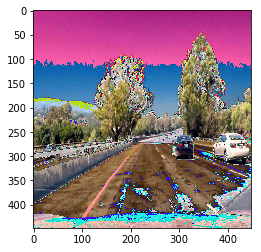

In [11]:
# np_img_origin = cv2.imread('test/my_testset/person.jpg')
np_img_origin = cv2.imread('test/test1.jpg')
resized_img = cv2.resize(np_img_origin, (448, 448))
np_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
np_img = 2*(np_img/255.) - 1
np_img = np_img.astype(np.float32)
plt.imshow(np_img)
np_img = np.expand_dims(np_img, axis=0)
# np_img = np_img / 255.0 * 2 - 1
# np_img = np.reshape(np_img, (1, 448, 448, 3))

net_out = model.predict(np_img)
out_img = post_progress(net_out[0], im=np_img_origin, is_save=True, threshold=0.01)
# plt.imshow(out_img)
